张峪齐 3200105176

### 第一题

#### 题目

利用PCA 进行面部识别

第一步：从https://pan.zju.edu.cn/share/4f8a7baa9837d15018d462e9a4 下载数据。

第二步：加载数据

第三步：降维

第四步：建立分类模型

第五步：性能度量（比较降维前后性能的差异）

#### 解答

##### 加载数据

In [1]:
import cv2
import numpy as np
def loadData(path):
    '''
    该函数传入数据集文件夹路径，返回数据集
    返回的数据集为一个numpy矩阵，其中每一行是一个图像的数据
    '''
    dataSet=np.array([])
    dataset=[]
    classVec=[]
    for i in range(1,41):
        path0=path+'/s'+str(i)
        for j in range(1,11):
            path_bmp=path0+'/'+str(j)+'.bmp'
            #dataSet[(i-1)*10+j,:]=cv2.imread(path_bmp,0).reshape(1,-1)
            dataset.append(cv2.imread(path_bmp,0).flatten())
            dataSet=np.mat(np.array(dataset,dtype="uint8"))
            classVec.append(i)
            #print(img.shape)  #所有图片的shape都是(112,92)        
    #print(f"dataSet.shape={dataSet.shape}")
    return dataSet,np.array(classVec)

dataSet,classVec=loadData('./orl')

##### 降维

计算协方差矩阵的特征值将花费极长的时间（可能是在本例中协方差矩阵不满秩？）故改为使用奇异值分解


设一个数据集有m个n维数据，表示为矩阵$X_{m \times n}$

该矩阵的SVD为：$X_{m \times n} = U_{m \times m} \Sigma _{m \times n} V_{n \times n}^T$ (若考虑复数则为$V_{n \times n}^H$)

又：使用```np.cov(X,rowvar=0)```计算X的协方差矩阵，结果为$X^TX$

则有$X_{n \times m}^TX_{m \times n}=V_{n \times n} \Sigma _{n \times m}^T \Sigma _{m \times n} V_{n \times n}^T$

则可以发现，X的右奇异向量矩阵v就是X协方差矩阵的特征向量矩阵

另外，奇异值矩阵$\Sigma _{m \times n}$中的奇异值序列自然是有序排列的,省去了排序

由此我们可以将示例代码中做如下修改，将代码片段：

```
covMat = np.cov(meanRemoved, rowvar=0)#计算协方差矩阵
eigVals,eigVects = np.linalg.eig(np.mat(covMat))                    
eigValInd = np.argsort(eigVals) #sort, sort goes smallest to largest
eigValInd = eigValInd[:-(topNfeat+1):-1] #cut off unwanted dimensions
redEigVects = eigVects[:,eigValInd] #reorganize eig vects largest to smallest
```

改为：

```
u, s, vh = np.linalg.svd(dataMat)
v=vh.T
redEigVects = v[:,:topNfeat]

```
由于只有400个奇异值，因此可以想到topNfeat取400以内才是有意义的

In [2]:
def pca(dataMat, topNfeat=9999999):
    '''
    参数：数据集矩阵，取主要特征的数量
    返回：以主成分表示的数据集矩阵
    '''
    meanVals = np.mean(dataMat, axis=0)
    meanRemoved = dataMat - meanVals #标准化
    
    u, s, vh = np.linalg.svd(meanRemoved)
    v=vh.T
    #print(s)
    redEigVects = v[:,:topNfeat]
    print(f"所选特征值和占总特征值和之比{sum(s[:topNfeat]**2)/sum(s**2)}")
    #covMat = np.cov(meanRemoved, rowvar=0)#计算协方差矩阵, np.cov(X,rowvar=0) = (X^T)X
    #eigVals,eigVects = np.linalg.eig(np.mat(covMat))                    
    #print(eigVals.shape)
    #print(eigVals)
    #eigValInd = np.argsort(eigVals) #sort, sort goes smallest to largest
    #eigValInd = eigValInd[:-(topNfeat+1):-1] #cut off unwanted dimensions
    #redEigVects = eigVects[:,eigValInd] #reorganize eig vects largest to smallest
    lowDDataMat = meanRemoved * redEigVects#transform data into new dimensions
    reconMat = (lowDDataMat * redEigVects.T) + meanVals
    return lowDDataMat, reconMat
    
pca(dataSet,100)

#test=np.mat([[-2,-3,1],[2,3,-1]])
#test_cov=np.cov(test,rowvar=0)
#print(test)
#print("\n")
#print(test_cov)
#print("\n")
#print(np.linalg.svd(test))
#print("\n")
#print(np.linalg.eig(test_cov))

所选特征值和占总特征值和之比0.8905796822623976


(matrix([[-1531.17604911,  1072.18126719, -1867.02575339, ...,
            -29.8451226 ,   103.89477659,   -95.40523457],
         [-2975.89645415,   759.88308519,   461.81166492, ...,
             33.90952267,    70.44235595,   119.3806765 ],
         [-2696.44921967,   380.51575337, -1004.96184044, ...,
             12.01506814,   -40.74426834,   131.05164774],
         ...,
         [ -843.14794032,   949.73439324,  1541.14202448, ...,
            -62.05280966,   123.22484457,   148.03585803],
         [-1400.61765833,  1276.41046965,   806.91098888, ...,
           -131.91627014,    45.13411479,    63.6797419 ],
         [ -534.83465374,   476.89207046,  2058.98859097, ...,
             -9.88220458,   204.38033356,     4.25254952]]),
 matrix([[ 50.37614075,  50.47239725,  51.36679253, ...,  43.40426149,
           39.08335592,  32.51565371],
         [ 67.80081274,  71.61023321,  76.02869058, ...,  18.81029243,
           28.05415364,  18.01340539],
         [ 45.56303531,  48.7814

##### 建立分类模型

划分训练数据与测试数据

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataSet, classVec, random_state=2023)


使用sklearn训练KNN模型进行分类，并测试准确率

In [4]:
from sklearn.neighbors import KNeighborsClassifier
def knn_by_sklearn(X_train,y_train,X_test,y_test,k):
    X_tr=np.array(X_train)
    X_te=np.array(X_test)
    neigh=KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_tr,y_train)
    y_predict=neigh.predict(X_te)
    
    #统计准确率
    error=0
    for i in range(0,len(y_predict)):
        if y_predict[i]!=y_test[i]:
            error=error+1
            #print(f"错误地将第 {y_test[i]} 人识别为第 {y_predict[i]} 人")
    accuracy=1-error/len(y_predict)
    
    return y_predict,accuracy

##### 性能度量

使用一半的数据作为训练数据，另一半作为测试数据。
同时，只考虑一个最近邻居

测试结果如下


选取前3重要的特征与1个最近邻
所选特征值和占总特征值和之比0.37357228504485623
识别准确率为:
0.655

选取前4重要的特征与1个最近邻
所选特征值和占总特征值和之比0.4293617134783418
识别准确率为:
0.6950000000000001

选取前5重要的特征与1个最近邻
所选特征值和占总特征值和之比0.48046084033017455
识别准确率为:
0.765

选取前10重要的特征与1个最近邻
所选特征值和占总特征值和之比0.5995186153355092
识别准确率为:
0.86

选取前20重要的特征与1个最近邻
所选特征值和占总特征值和之比0.7001464675567803
识别准确率为:
0.88

选取前30重要的特征与1个最近邻
所选特征值和占总特征值和之比0.753280380217233
识别准确率为:
0.895

选取前40重要的特征与1个最近邻
所选特征值和占总特征值和之比0.7894503592571359
识别准确率为:
0.89

选取前50重要的特征与1个最近邻
所选特征值和占总特征值和之比0.8160502357792209
识别准确率为:
0.88

选取前70重要的特征与1个最近邻
所选特征值和占总特征值和之比0.8535664947576842
识别准确率为:
0.885

选取前90重要的特征与1个最近邻
所选特征值和占总特征值和之比0.8798769527705114
识别准确率为:
0.895

选取前100重要的特征与1个最近邻
所选特征值和占总特征值和之比0.8905796822623976
识别准确率为:
0.895


Text(0, 0.5, 'accuracy')

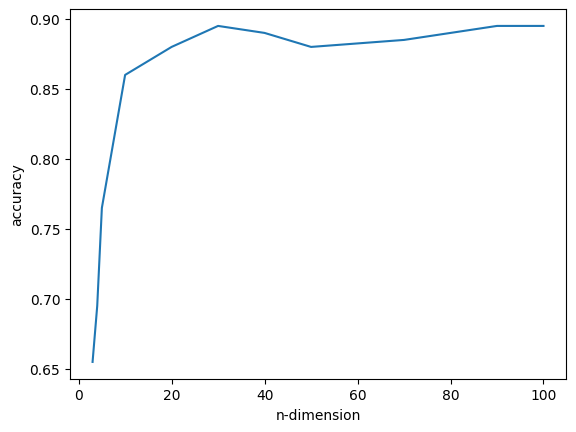

In [6]:
import matplotlib.pyplot as plt

plt.figure()
k_values=[3,4,5,10,20,30,40,50,70,90,100]
accuracy_values=[]
for k in k_values:
    print(f"\n选取前{k}重要的特征与1个最近邻")
    dataSet,classVec=loadData('./orl')
    lowDData, dataSet=pca(dataSet,k)
    X_train, X_test, y_train, y_test = train_test_split(lowDData, classVec,test_size=0.5,random_state=2023)
    y_predict,accuracy=knn_by_sklearn(X_train,y_train,X_test,y_test,1)
    
    print("识别准确率为:")
    print(accuracy)
    accuracy_values.append(accuracy)
plt.plot(k_values,accuracy_values)
plt.xlabel("n-dimension")
plt.ylabel("accuracy")



### 第二题


#### 题目

利用SVM自然图片分类（实验手册练习Chars74K 数据集）

### 解答

#### 从零实现SVM在自然图片上的分类

In [3]:
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
#from thundersvm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from PIL import Image
X = []
y = []
for path, subdirs, files in os.walk('./English/Img/GoodImg/Bmp/'):
    for filename in files:
        f = os.path.join(path, filename)
        target = filename[3:filename.index('-')]
        img = Image.open(f).convert('L').resize((30, 30), resample=Image.LANCZOS)
        X.append(np.array(img).reshape(900,))
        y.append(target)
X = np.array(X)
print(X.shape)

(7705, 900)


##### 使用sklearn实现分类识别

In [4]:
X = X/255.0*2 - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=11)

pipeline = Pipeline([('clf', SVC(kernel='rbf', gamma=0.01, C=100))])
parameters = {
    'clf__gamma': (0.01, 0.03, 0.1, 0.3, 1),
    'clf__C': (0.1, 0.3, 1, 3, 10, 30),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=2, verbose=1, scoring='accuracy')
grid_search.fit(X_train[:5000], y_train[:5000])
print('Best score: %0.3f' % grid_search.best_score_)
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(X_test)
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best score: 0.573
Best parameters set:
	clf__C: 10
	clf__gamma: 0.01
              precision    recall  f1-score   support

         001       0.53      0.30      0.38        27
         002       0.73      0.44      0.55        18
         003       0.67      0.33      0.44        18
         004       0.60      0.43      0.50         7
         005       1.00      0.25      0.40        12
         006       1.00      0.18      0.31        11
         007       0.80      0.36      0.50        11
         008       1.00      0.50      0.67         8
         009       0.00      0.00      0.00         3
         010       0.50      0.33      0.40         3
         011       0.67      0.95      0.78       119
         012       0.36      0.38      0.37        21
         013       0.69      0.73      0.71        45
         014       0.73      0.59      0.65        46
         015       0.61      0.87      0.72        86
    

D:\miniConda\envs\d2l\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniConda\envs\d2l\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniConda\envs\d2l\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
